In [1]:
import torch
from torchvision import transforms
from PIL import Image
import os
from skimage import filters, measure
import inspect


class PrecipitationAnalyzer:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def load_image_as_tensor(path):
        image = Image.open(path).convert("L")
        transform = transforms.ToTensor()
        tensor = transform(image).to(PrecipitationAnalyzer.device)
        return tensor

    @staticmethod
    def calculate_intensity(image_paths):
        intensities = []
        for path in image_paths:
            tensor = PrecipitationAnalyzer.load_image_as_tensor(path)
            intensity = tensor.sum().item()
            intensities.append(intensity)
        return torch.tensor(intensities, device=PrecipitationAnalyzer.device).mean().item()

    @staticmethod
    def calculate_density(image_paths):
        densities = []
        for path in image_paths:
            tensor = PrecipitationAnalyzer.load_image_as_tensor(path)
            density = (tensor > 0).float().mean().item()
            densities.append(density)
        return torch.tensor(densities, device=PrecipitationAnalyzer.device).mean().item()

    @staticmethod
    def calculate_complexity(image_paths):
        complexities = []
        for path in image_paths:
            tensor = PrecipitationAnalyzer.load_image_as_tensor(path)
            tensor_np = tensor.cpu().numpy()[0]  # Convert to NumPy array for skimage processing
            edges = filters.sobel(tensor_np)
            complexity = measure.shannon_entropy(edges)
            complexities.append(complexity)
        return torch.tensor(complexities, device=PrecipitationAnalyzer.device).mean().item()

    @staticmethod
    def analyze(image_paths):
        methods = inspect.getmembers(PrecipitationAnalyzer, predicate=inspect.isfunction)
        results = {}
        for name, method in methods:
            if name.startswith("calculate_") and name != "analyze":
                result = method(image_paths)
                results[name[len("calculate_") :]] = result
        return results

In [2]:
import os
from datetime import datetime
# from PrecipitationAnalyzer import PrecipitationAnalyzer


class FileProcessor:
    def __init__(self, directory, sequence_length):
        self.directory = directory
        self.sequence_length = sequence_length

    def get_subdirectories(self):
        """Get a list of subdirectories in the main directory."""
        return [
            os.path.join(self.directory, subdir)
            for subdir in os.listdir(self.directory)
            if os.path.isdir(os.path.join(self.directory, subdir))
        ]

    def get_file_list(self, subdirectory):
        """Get a sorted list of files in a given subdirectory."""
        files = []
        for root, _, filenames in os.walk(subdirectory):
            for filename in filenames:
                if filename.endswith(".png"):
                    files.append(os.path.join(root, filename))
        files.sort()  # Sort the files by name to ensure time sequence order
        return files

    def generate_time_sequences(self, files):
        """Generate time sequences from the list of files."""
        time_sequences = []
        for i in range(len(files) - self.sequence_length + 1):
            time_sequences.append(files[i : i + self.sequence_length])
        return time_sequences

    def analyze_sequences(self, subdirectory):
        files = self.get_file_list(subdirectory)
        if len(files) < self.sequence_length:
            return []  # Skip subdirectory if it has fewer files than the sequence length

        sequences = self.generate_time_sequences(files)
        results = []
        for sequence in sequences:
            analysis = PrecipitationAnalyzer.analyze(sequence)
            start_time_str = sequence[0].split("/")[-1].split(".")[0]  # Extracting date and time from filename
            end_time_str = sequence[-1].split("/")[-1].split(".")[0]
            start_time = datetime.strptime(start_time_str, "%Y%m%d_%H%M")
            end_time = datetime.strptime(end_time_str, "%Y%m%d_%H%M")
            sequence_name = f"{start_time.strftime('%Y%m%d_%H%M')}-{end_time.strftime('%Y%m%d_%H%M')}"
            results.append({"sequence": sequence_name, **analysis})
        return results

    def sort_and_rank(self, results):
        keys = results[0].keys() - {"sequence"}
        ranked_results = {}
        for key in keys:
            sorted_results = sorted(results, key=lambda x: x[key])
            for i, result in enumerate(sorted_results):
                if key not in ranked_results:
                    ranked_results[key] = []
                ranked_results[key].append((i, result["sequence"], result[key]))
        return ranked_results

    def find_extreme_and_median_sequences(self, ranked_results):
        extremes = {}
        for key, values in ranked_results.items():
            filtered_values = [v for v in values if v[2] > 0]
            n = len(filtered_values)
            if n == 0:
                extremes[key] = {"min": None, "max": None, "median": None}
            else:
                min_seq = filtered_values[0][1]
                max_seq = filtered_values[-1][1]
                median_seq = filtered_values[n // 2][1]
                extremes[key] = {"min": min_seq, "max": max_seq, "median": median_seq}
        return extremes

    def process(self):
        subdirectories = self.get_subdirectories()
        all_results = []
        for subdirectory in subdirectories:
            print(f"processing: {subdirectory}, \nwith cuda: {torch.cuda.is_available()}")
            results = self.analyze_sequences(subdirectory)
            if results:
                all_results.extend(results)

        if not all_results:
            return [], {}, {}

        ranked_results = self.sort_and_rank(all_results)
        extremes = self.find_extreme_and_median_sequences(ranked_results)
        return all_results, ranked_results, extremes

In [3]:
directory = "/home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test"
sequence_length = 8
processor = FileProcessor(directory, sequence_length)
results, ranked_results, extremes = processor.process()
print("Extreme and Median Sequences:", extremes)

processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230124, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230125, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230129, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230130, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230131, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230201, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_processed/test/20230202, 
with cuda: True
processing: /home/zhexu_umass_edu/PycharmProjects/SPRITE/skillful_nowcasting/netCDFData_pr

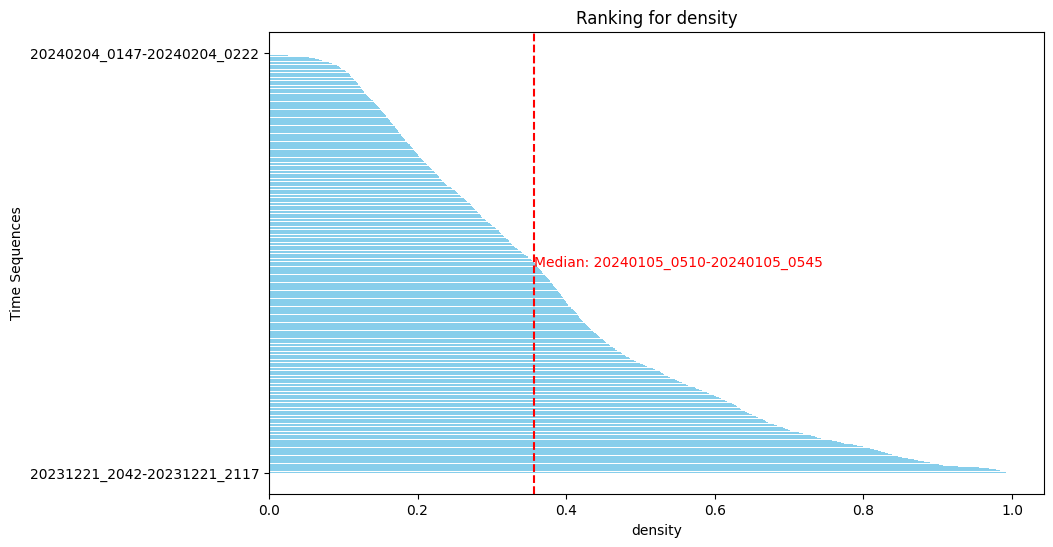

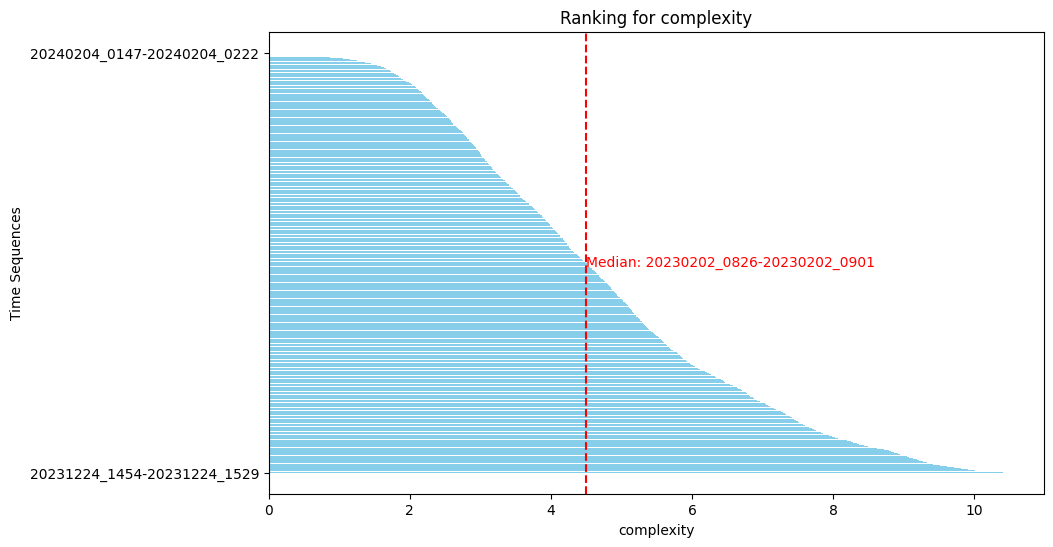

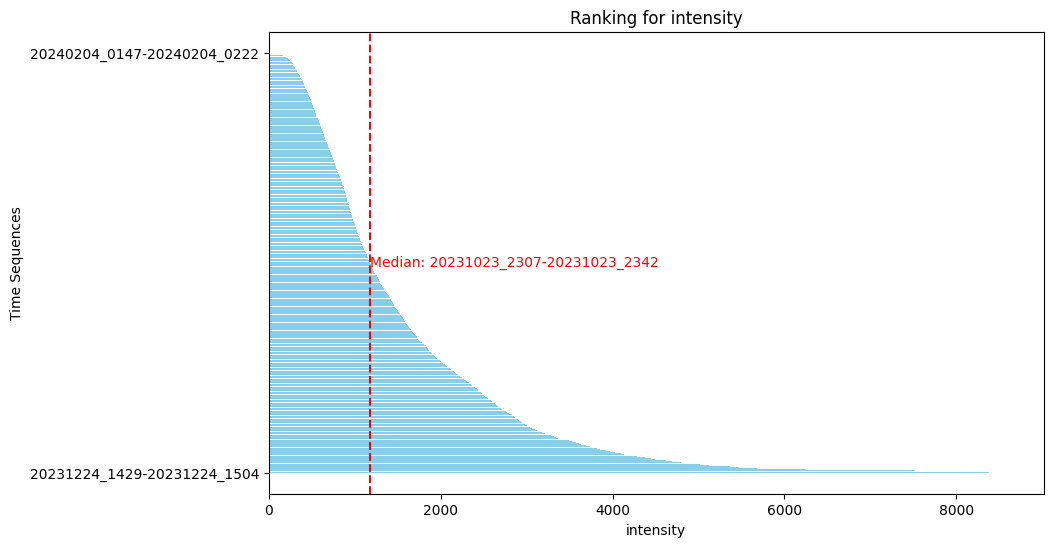

In [4]:
import matplotlib.pyplot as plt


def plot_ranked_results(ranked_results):
    for key, values in ranked_results.items():
        sequences = [item[1] for item in values]
        scores = [item[2] for item in values]

        plt.figure(figsize=(10, 6))
        plt.barh(sequences, scores, color="skyblue")
        plt.xlabel(key)
        plt.ylabel("Time Sequences")
        plt.title(f"Ranking for {key}")

        # Mark the median
        n = len(values)
        median_index = n // 2
        median_value = values[median_index][2]
        median_sequence = values[median_index][1]

        plt.axvline(x=median_value, color="red", linestyle="--")
        plt.text(median_value, median_index, f"Median: {median_sequence}", va="center", color="red")

        plt.yticks([0, len(sequences) - 1], [sequences[0], sequences[-1]])
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top

        plt.show()


plot_ranked_results(ranked_results)

In [5]:
print(ranked_results)

{'density': [(0, '20240204_0147-20240204_0222', 0.0), (1, '20240204_0152-20240204_0227', 0.0), (2, '20240204_0157-20240204_0232', 0.0), (3, '20240204_0202-20240204_0237', 0.0), (4, '20240204_0207-20240204_0242', 0.0), (5, '20240204_0212-20240204_0247', 0.0), (6, '20240204_0217-20240204_0252', 0.0), (7, '20240204_0222-20240204_0257', 0.0), (8, '20240204_0227-20240204_0302', 0.0), (9, '20240204_0232-20240204_0307', 0.0), (10, '20240204_0237-20240204_0312', 0.0), (11, '20240204_0242-20240204_0317', 0.0), (12, '20240204_0247-20240204_0322', 0.0), (13, '20240204_0252-20240204_0327', 0.0), (14, '20240204_0257-20240204_0332', 0.0), (15, '20240204_0302-20240204_0337', 0.0), (16, '20240204_0307-20240204_0342', 0.0), (17, '20231022_1353-20231022_1428', 9.5367431640625e-06), (18, '20231022_1358-20231022_1433', 1.71661376953125e-05), (19, '20231022_1403-20231022_1438', 1.71661376953125e-05), (20, '20231022_1408-20231022_1443', 1.71661376953125e-05), (21, '20231022_1413-20231022_1448', 1.7166137695